# Questions 

1) Overlaying to screen data, and/or DEGS. I think we are particulary interested in repressors that go down with hypothermia or activators that go up with hypothermia 
2) might be interesting to plot individual plots for known cold induced genes (CIRBP, RBM3; SMYD5) and see which other genes mirror or are opposite

# Import, options

In [11]:
import numpy, seaborn, pandas
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt

import statsmodels.api

from statsmodels.stats.multitest import multipletests
from scipy.stats import linregress
from scipy.stats import f_oneway

In [12]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [13]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# Data Download

In [43]:
#data Proteomics
df = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv', 
                     sep = ',', index_col = 'Gene')
df = df.iloc[:,4:-3]

df.columns = df.columns.str.split('_').str[0]
df = df.groupby(axis=1, level=0).median()
df = df[['Ctrl', '3h', '6h', '9h', '12h', '16h']]

print(df.shape, '\n')
df.head(3)

(2405, 6) 



C:\Users\kja11\AppData\Local\Temp\ipykernel_13184\1013410039.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).median()


,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,92.9,96.6,91.6,105.8,103.0,115.5
LARP1,103.3,106.6,103.5,99.1,95.3,93.2
ACTB,100.9,107.1,102.3,94.4,93.9,100.4


In [44]:
# List of filtered proteins
proteomics_path = file_directory + "3) output/Proteomics/"

with open(proteomics_path+'Early_res_CoeffVar_proteins.txt') as f:
    Early_res_CoeffVar_proteins = f.read().splitlines()
    
with open(proteomics_path+'high_CoeffVar_proteins.txt') as f:
    high_CoeffVar_proteins = f.read().splitlines()

with open(proteomics_path+'high_Rvalue_linregress_proteins.txt') as f:
    high_Rvalue_linregress_proteins = f.read().splitlines()
    
print("Early_res_CoeffVar_proteins:", len(Early_res_CoeffVar_proteins))
print("high_CoeffVar_proteins:", len(high_CoeffVar_proteins))
print("high_Rvalue_linregress_proteins:", len(high_Rvalue_linregress_proteins))

Early_res_CoeffVar_proteins: 179
high_CoeffVar_proteins: 174
high_Rvalue_linregress_proteins: 302


### Linregress data

In [60]:
df_linregress = pandas.read_csv(file_directory+'3) output/Proteomics/df_linregress_noCTL.csv', 
                     sep = ',', index_col = 'Gene')

df_linregress.head()

,slope,intercept,rvalue,pvalue,adj_pvalue
Gene,,,,,
DIS3,1.515694,87.275616,0.805491,0.000290,0.040984
LARP1,-1.009533,108.867704,-0.877613,0.000017,0.019899
ACTB,-0.490661,104.354086,-0.435866,0.104359,0.316498
PSMA2,-0.902140,108.073022,-0.692949,0.004183,0.087465
PRRC1,-0.928729,108.084306,-0.461475,0.083357,0.276843


# Data transformation

### To Zscore

In [45]:
df_zscore = stats.zscore(df, axis = 0)
df_zscore.head(2)

,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,-1.092419,-0.367305,-1.569021,0.917407,0.601398,2.127101
LARP1,0.748607,1.131631,0.843713,-0.246745,-0.859439,-1.056857


### Subset

In [48]:
df_linregress = df[df.index.isin(high_Rvalue_linregress_proteins)]
df_early_res =  df[df.index.isin(Early_res_CoeffVar_proteins)]
df_high_CV =  df[df.index.isin(high_CoeffVar_proteins)]

print(len(df_linregress))
print(len(df_early_res))
print(len(df_high_CV))

302
179
174


# Methods

## Slope of all the proteins identified

In [61]:
df_linregress.reset_index(inplace = True)

#define the colors
colors = ['blue' if x < -0.5 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'red' if x > 0.5 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'black' if x > -0.5 and x < 0.5
          else 'grey' for x, y in zip(df_linregress['slope'], 
                                      df_linregress['adj_pvalue'])]

blue_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'blue']
red_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'red']
grey_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'grey']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
grey_genes_n = len(set(grey_indices))

2405 



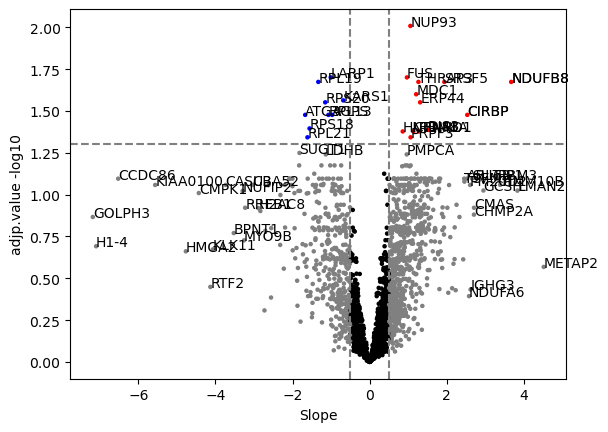

In [62]:
# Plot all the protein from their slope value
## Plot, after convertion  y to log10(pvalue)
top_pvalue = df_linregress.sort_values(by='adj_pvalue', ascending=True).head(25)
top_neg_slope = df_linregress.sort_values(by='slope', ascending=True).head(15)
top_pos_slope = df_linregress.sort_values(by='slope', ascending=False).head(15)

print(len(df_linregress), '\n')
plt.scatter(x=df_linregress['slope'], 
            y=df_linregress['adj_pvalue'].apply(lambda x:-numpy.log10(x)),
            s=5,
            c = colors)

plt.xlabel("Slope")
plt.ylabel("adjp.value -log10")

# Annotate points on the plot with Symbol names
for index, row in top_pvalue.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
for index, row in top_neg_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
for index, row in top_pos_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
# pvalue <0.05
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")
plt.axvline(-0.5,color="grey",linestyle="--")
plt.axvline(0.5,color="grey",linestyle="--")

# title_file = 'volcano_proteomic_slope'
plt.savefig(file_directory+'3) output/Proteomics/'+'volcano_slope_proteomics_adjpval'+'.svg')

In [63]:
#define the colors
colors = ['blue' if x < -0.6 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'red' if x > 0.6 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'black' if x > -0.6 and x < 0.6
          else 'grey' for x, y in zip(df_linregress['rvalue'], 
                                      df_linregress['adj_pvalue'])]

blue_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'blue']
red_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'red']
grey_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'grey']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
grey_genes_n = len(set(grey_indices))

In [64]:
# Plot all the protein from their slope value
## Plot, after convertion  y to log10(pvalue)
df_linregress_high_Rval = df_linregress[df_linregress['Gene'].isin(high_Rval_prot)]
print(len(df_linregress_high_Rval))

top_neg_slope = df_linregress_high_Rval.sort_values(by='rvalue', ascending=True).head(15)
top_pos_slope = df_linregress_high_Rval.sort_values(by='rvalue', ascending=False).head(15)


plt.scatter(x=df_linregress['rvalue'], 
            y=df_linregress['adj_pvalue'].apply(lambda x:-numpy.log10(x)),s=5,
            c= colors)

plt.xlabel("rvalue")
plt.ylabel("adjp.value -log10")

# Annotate points on the plot with Symbol names
for index, row in top_neg_slope.iterrows():
    plt.annotate(row['Gene'], (row['rvalue'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
for index, row in top_pos_slope.iterrows():
    plt.annotate(row['Gene'], (row['rvalue'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
# pvalue <0.05
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")
plt.axvline(-0.6,color="grey",linestyle="--")
plt.axvline(0.6,color="grey",linestyle="--")

# plt.savefig(file_directory+'3) output/Proteomics/'+'volcano_high_rvalue_proteomics_adjpval'+'.svg')

NameError: name 'high_Rval_prot' is not defined

## Check if our known targets are well affected at 32°C

In [143]:
# Select the targets and only select expression columns
df_targets =  df[ (df.index == 'CIRBP') | (df.index == 'RBM3') | (df.index == 'SMYD5')]
df_targets

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
CIRBP,79.2,101.4,88.4,78.7,92.5,96.6,86.9,84.4,94.5,96.3,95.7,113.2,126.1,113.9,98.2,114.9,121.1,117.9
RBM3,80.3,90.6,85.4,79.8,85.5,94.5,88.8,83.5,98.6,102.3,98.5,102.7,104.8,88.9,121.1,127.3,104.0,163.3
SMYD5,101.6,100.2,111.3,119.4,121.4,98.9,95.0,119.9,101.0,82.8,107.0,100.5,96.7,98.9,91.0,78.6,81.2,94.7


In [144]:
# From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()}, \n')

# Print linregess results for the targets
print(df_linregress[(df_linregress['Gene'] == 'CIRBP')|(df_linregress['Gene'] == 'RBM3')
                    |(df_linregress['Gene'] == 'SMYD5')])

seaborn.lineplot(data = df_targets, x='conditions' , y='value', hue= "Gene",
                err_style="bars", errorbar=('se', 0.5))
plt.ylabel("Protein abundance by TMT reporter ion intensity")
plt.xlabel("")
plt.show()
plt.close()

# Expression of the target proteins over time
targets = ['CIRBP', 'RBM3', 'SMYD5']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

    Gene conditions  value
0  CIRBP       Ctrl   79.2
1   RBM3       Ctrl   80.3
2  SMYD5       Ctrl  101.6
3  CIRBP       Ctrl  101.4
4   RBM3       Ctrl   90.6, 



KeyError: 'Gene'

## Overlap with RNAseq

The overlapping targets are CHORDC1, NOC3L, CIRBP, SRSF5, RBM3 and HNRNPDL

In [20]:
# Select the overlapping targets and only select expression columns
df_targets =  df[ (df.index == 'CIRBP') | (df.index == 'RBM3') | (df.index == 'SRSF5')
                 | (df.index == 'HNRNPDL') | (df.index == 'CHORDC1') | (df.index == 'NOC3L')]

df_targets

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
SRSF5,87.4,99.4,89.2,78.1,98.1,96.5,96.9,93.8,90.1,100.6,96.5,105.3,102.4,106.6,114.4,109.9,116.7,117.8
CIRBP,79.2,101.4,88.4,78.7,92.5,96.6,86.9,84.4,94.5,96.3,95.7,113.2,126.1,113.9,98.2,114.9,121.1,117.9
CHORDC1,99.4,103.0,109.1,95.9,110.9,107.1,97.3,101.1,103.8,100.6,108.4,100.7,102.2,92.2,92.7,90.1,96.3,89.2
RBM3,80.3,90.6,85.4,79.8,85.5,94.5,88.8,83.5,98.6,102.3,98.5,102.7,104.8,88.9,121.1,127.3,104.0,163.3
NOC3L,121.4,106.4,97.1,94.0,85.5,95.3,93.3,83.7,90.2,98.8,92.3,98.9,109.9,110.4,95.5,130.1,101.4,95.8
HNRNPDL,100.8,98.6,94.6,95.6,98.7,101.2,96.1,96.9,98.5,97.8,102.2,103.6,96.5,103.8,97.5,109.4,101.9,106.2


      Gene conditions  value
0    SRSF5       Ctrl   87.4
1    CIRBP       Ctrl   79.2
2  CHORDC1       Ctrl   99.4
3     RBM3       Ctrl   80.3
4    NOC3L       Ctrl  121.4, 

Empty DataFrame
Columns: [Gene, slope, rvalue, pvalue, adj_pvalue]
Index: []


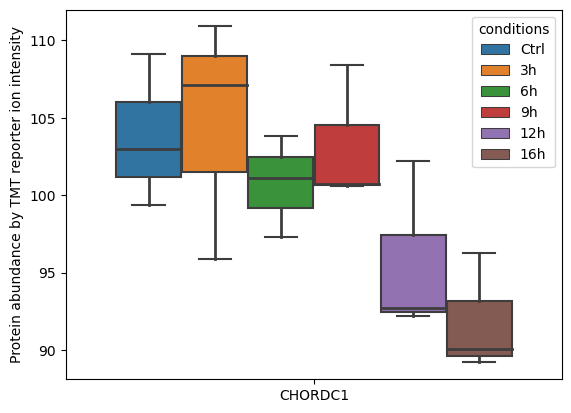

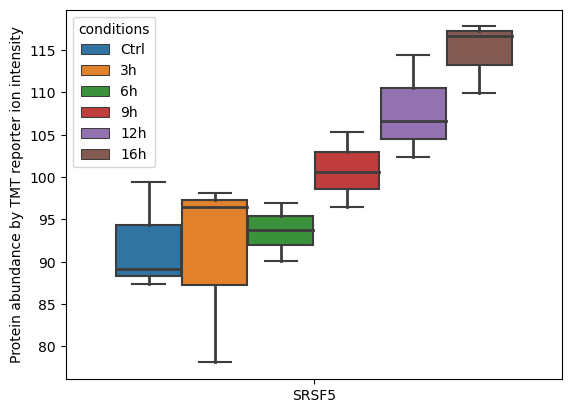

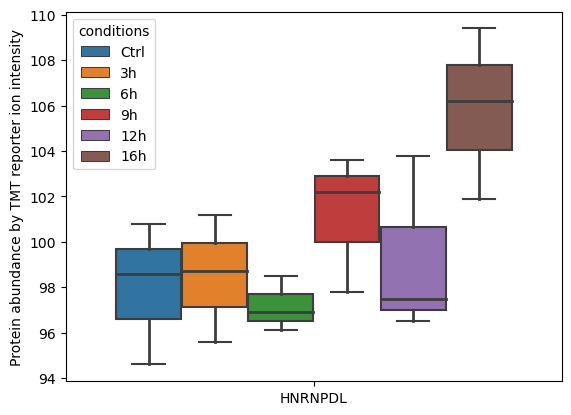

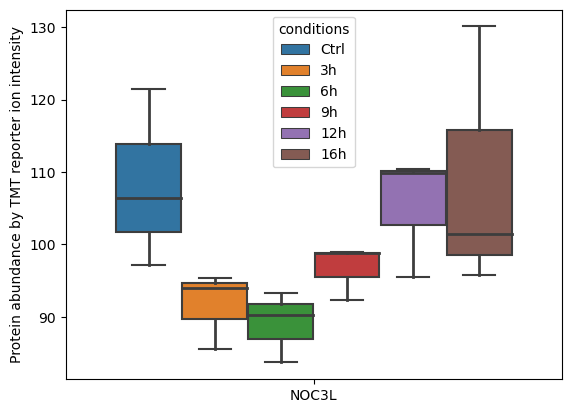

In [21]:
# Protein expression over time of the overlapped proteins.
## From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()}, \n')

## Print linregess results for the targets
print(df_linregress[(df_linregress.index == 'CIRBP')|(df_linregress.index == 'RBM3')|(df_linregress.index == 'SMYD5')])


## Expression of the target proteins over time
# targets = ['CHORDC1', 'CIRBP', 'SRSF5', 'RBM3', 'HNRNPDL']
targets = ['CHORDC1', 'SRSF5', 'HNRNPDL', 'NOC3L']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

## Heatmap from expression

### Heatmap Linregress significant proteins only

In [22]:
# Count number of cells in specific interval to select heatmap vmin/vmax
values = df_zscore[df_zscore.index.isin(signif_nonAjd_linregress_proteins)].values.flatten()
bin_edges = numpy.arange(-6, 8, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
# print(count_df.head(3), '\n', count_df.tail(10))
print(count_df)

    Interval  Count
0   -6 to -5      0
1   -5 to -4      2
2   -4 to -3      7
3   -3 to -2     23
4   -2 to -1    214
5    -1 to 0   1462
6     0 to 1   1271
7     1 to 2    176
8     2 to 3     23
9     3 to 4     10
10    4 to 5      2
11    5 to 6      2
12    6 to 7      0


number of proteins: 532


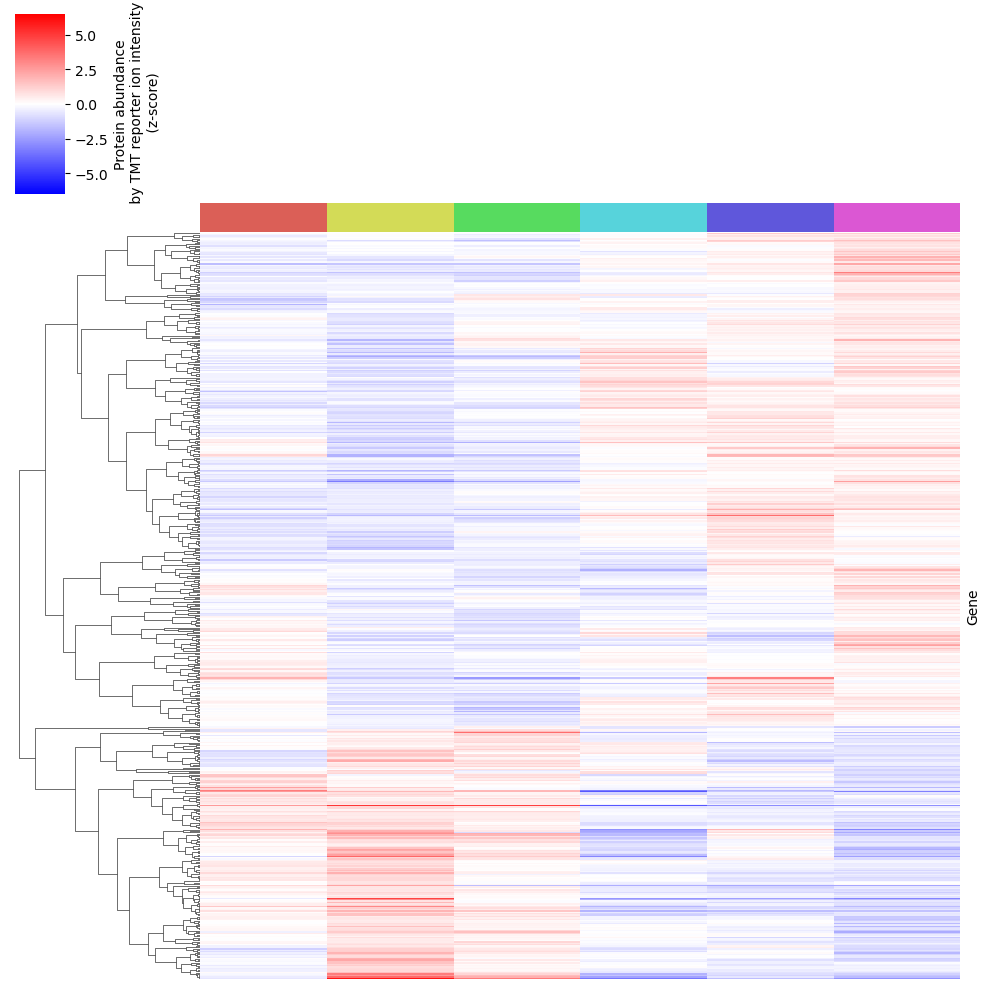

In [23]:
# Same but with Linregress significant only
## define the colors, one color per condition 
lut = dict(zip(df_zscore.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_zscore.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_zscore[df_zscore.index.isin(signif_nonAjd_linregress_proteins)]))

seaborn.clustermap(df_zscore[df_zscore.index.isin(signif_nonAjd_linregress_proteins)], 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-6.5, vmax=6.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

## Only adjusted pvalue

In [24]:
# Count number of cells in specific interval to select heatmap vmin/vmax
df_sign_adjpav = df_zscore[df_zscore.index.isin(adjPvalue_signif_linregress_proteins)]
print(len(df_sign_adjpav), df_sign_adjpav.min().min(), df_sign_adjpav.max().max(), '\n')

values = df_sign_adjpav.values.flatten()
bin_edges = numpy.arange(-4, 5, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

22 -1.6159670215891102 3.29937311631588 

   Interval  Count
0  -4 to -3      0
1  -3 to -2      0
2  -2 to -1     11
3   -1 to 0     59
4    0 to 1     55
5    1 to 2      5
6    2 to 3      1
7    3 to 4      1


number of proteins: 22


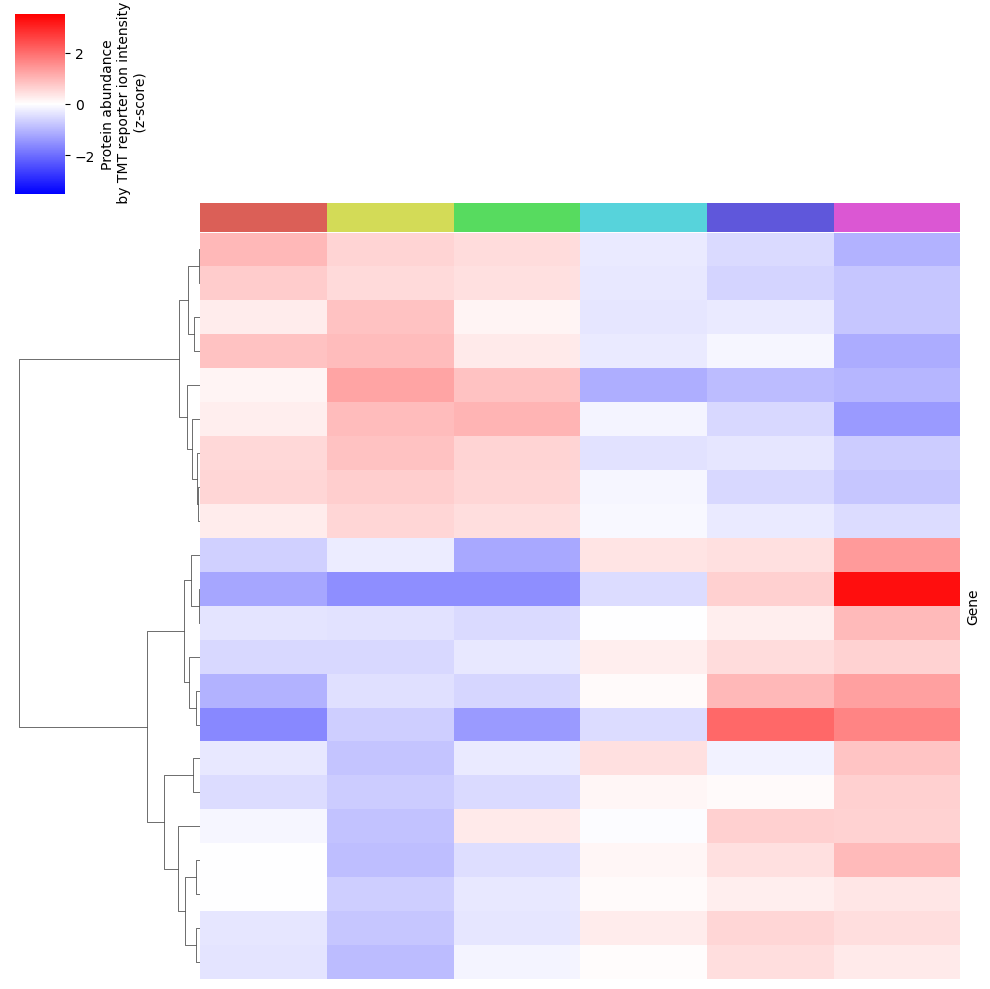

In [25]:
# Heatmap of proteins expression 
## define the colors, one color per condition 
lut = dict(zip(df_sign_adjpav.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_sign_adjpav.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_sign_adjpav))
seaborn.clustermap(df_sign_adjpav, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-3.5, vmax=3.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

### Heatmap of proteins with rvalue > 0.6 (abs)

In [26]:
# Count number of cells in specific interval to select heatmap vmin/vmax
df_high_Rval = df_zscore[df_zscore.index.isin(high_Rval_prot)]
print(len(df_high_Rval), df_high_Rval.min().min(), df_high_Rval.max().max(), '\n')

values = df_high_Rval.values.flatten()
bin_edges = numpy.arange(-6, 7, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

302 -4.310420870711283 5.965574649576533 

    Interval  Count
0   -6 to -5      0
1   -5 to -4      1
2   -4 to -3      4
3   -3 to -2     14
4   -2 to -1    122
5    -1 to 0    838
6     0 to 1    701
7     1 to 2    107
8     2 to 3     14
9     3 to 4      7
10    4 to 5      2
11    5 to 6      2


number of proteins: 302


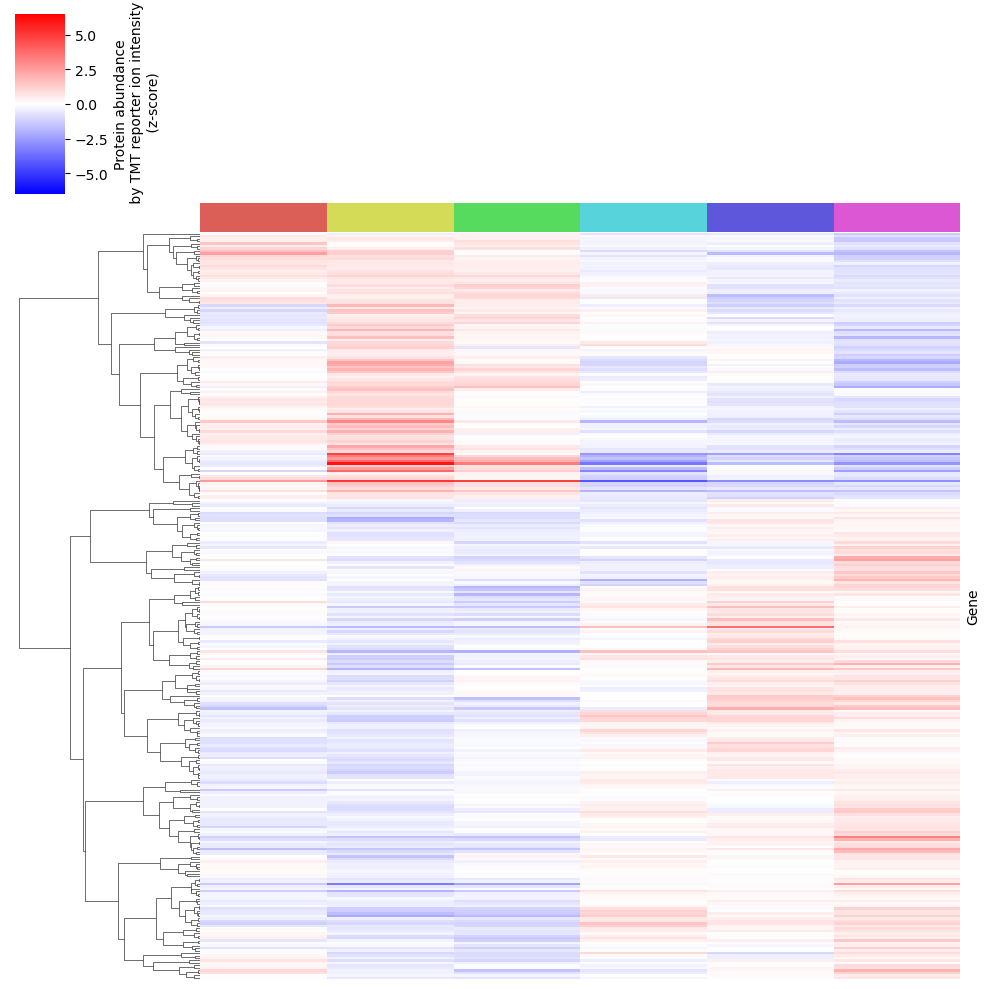

In [27]:
# Heatmap of proteins with rvalue > 0.6
## define the colors, one color per condition 
lut = dict(zip(df_high_Rval.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_high_Rval.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_high_Rval))
seaborn.clustermap(df_high_Rval, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-6.5, vmax=6.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

In [ ]:
# For more detail but not clustered
# plt.subplots(figsize=(8, 30))
# # plt.tight_layout()
# seaborn.heatmap(df_high_Rval, annot=False, cmap="bwr", 
#                 linewidths=0, center=0, vmin=-6.5, vmax=6.5,
#                 cbar_kws={'label': 'Zscore \n protein expression'})